# Chapitre 1

Bienvenue dans ce chapitre interactif utilisant ThebeLab !

## Exemple de code interactif

```{thebe-button}

```{code-cell} ipython3
:tags: [thebe-init]

import matplotlib.pyplot as plt
import numpy as np

def plot_sine(frequency=1):
    x = np.linspace(0, 10, 1000)
    y = np.sin(frequency * x)
    plt.figure(figsize=(8, 4))
    plt.plot(x, y)
    plt.title(f'Sine Wave with Frequency {frequency}')
    plt.xlabel('x')
    plt.ylabel('sin(x)')
    plt.show()

plot_sine()
```

hello

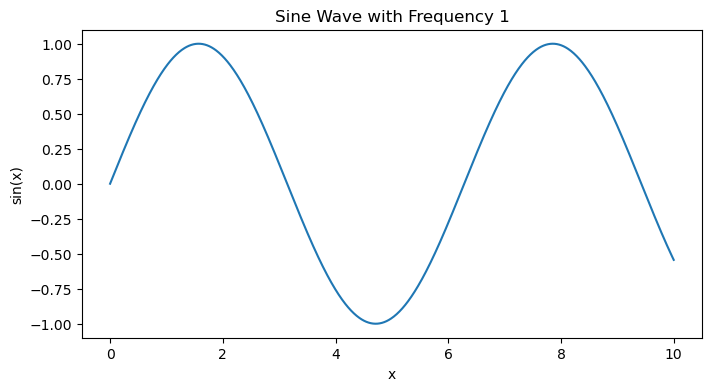

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sine(frequency=1):
    x = np.linspace(0, 10, 1000)
    y = np.sin(frequency * x)
    plt.figure(figsize=(8, 4))
    plt.plot(x, y)
    plt.title(f'Sine Wave with Frequency {frequency}')
    plt.xlabel('x')
    plt.ylabel('sin(x)')
    plt.show()

plot_sine()

hello3